# Bike Share Rebalancing Minimizer - Map (Phase 4)

### ACKNOWLEDGEMENTS:

Thanks to: [oliver dadoun](https://stackoverflow.com/questions/64792041/white-gap-between-python-folium-map-and-jupyter-notebook-cell)

### OBJECTIVES:

The objective of this section of the project is to use the predictive model created in the previous section to map the high vs. low projected ride-end ratio areas of Toronto. In other words, to make a map showing which prospective Bike Share station locations would have usage patterns that would lead to empty stations, and which locations would have usage patterns that would lead to full stations. This map could be used by Bike Share Toronto to anticipate a new station's burden on the rebalancing team, before adding that station to the network.

### DATA SOURCES:
   * See data aggregation file: [data.ipynb](https://github.com/stephensavoia/rebalancing_minimizer/blob/main/data.ipynb)

### STEPS:

   * [1. Import Elevation Data](#1)
   * [2. Predict Ride-End Ratios with Saved Model](#2)
   * [3. Plot Ride-End Ratios to Map](#3)

### 1. IMPORT ELEVATION DATA<a class="anchor" id="1"></a>

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as pltcols
import pyproj
import folium
from branca.element import Figure
import os
import joblib

In [2]:
# Import data
elevation_data = pd.read_parquet('elevation_data.parquet', engine='pyarrow')
elevation_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20435322 entries, 3521 to 15432612
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   utm_east   int32  
 1   utm_north  int32  
 2   elevation  float32
dtypes: float32(1), int32(2)
memory usage: 389.8 MB


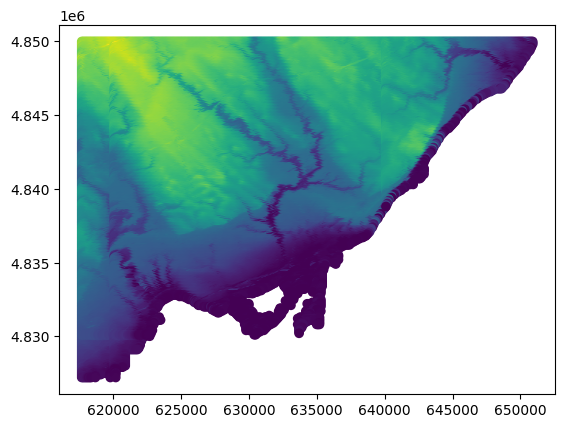

In [3]:
# Lower the resolution of the data, for faster processing
elevation_data = elevation_data[(elevation_data['utm_east'] % 100 == 0) & (elevation_data['utm_north'] % 100 == 0)]

# Remote locations that are underwater (i.e. in Lake Ontario)
elevation_data = elevation_data[elevation_data['elevation'] > 76]

# Reset index
elevation_data = elevation_data.reset_index(drop=True)

# View data
plt.scatter(elevation_data['utm_east'], elevation_data['utm_north'], c=elevation_data['elevation'])

In [4]:
# Make a transformer to change from utm to long/lat. CRS codes were found on https://epsg.io/
utm_to_lonlat = pyproj.Transformer.from_crs(32617, 4326)

# Make a data frame of lat/long coordinates for each set of UTM coordinates
latlon_data = pd.DataFrame(utm_to_lonlat.transform(elevation_data['utm_east'],elevation_data['utm_north'])).transpose()
latlon_data.columns = ['lat', 'lon']

# Update elevation_data
data = pd.concat([elevation_data, latlon_data], axis=1)

data.head(3)

utm_east  utm_north   elevation        lat        lon
0    617700    4830000  110.587196  43.613679 -79.541384
1    617800    4830000  110.658401  43.613663 -79.540145
2    617900    4830000  109.583603  43.613647 -79.538906

### 2. PREDICT RIDE-END RATIOS WITH SAVED MODEL<a class="anchor" id="2"></a>

In [5]:
# Import model
model = joblib.load("ride_end_ratio_model.pkl")

# Use the model to predict the ride-end ratio of each point on the map (and save the predictions to a new column in the data frame)
data['ride_end_ratio'] = model.predict(data[['lat', 'lon', 'elevation']])

data.head(3)

utm_east  utm_north   elevation        lat        lon  ride_end_ratio
0    617700    4830000  110.587196  43.613679 -79.541384        0.532414
1    617800    4830000  110.658401  43.613663 -79.540145        0.532414
2    617900    4830000  109.583603  43.613647 -79.538906        0.533995

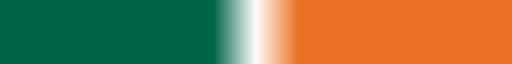

In [6]:
# Set colours, for use map (colour palette taken from Bike Share Toronto website)
c_1_hex = "#006448"
c_2_hex = "#ea7023"

# Create colour maps that match the theme of the project
# Use np.repeat to create as steeper color gradient, where necessary
cmap1 = pltcols.LinearSegmentedColormap.from_list(
    "", np.repeat(c_1_hex, 6).tolist() + ['white'] + np.repeat(c_2_hex, 6).tolist())

cmap1

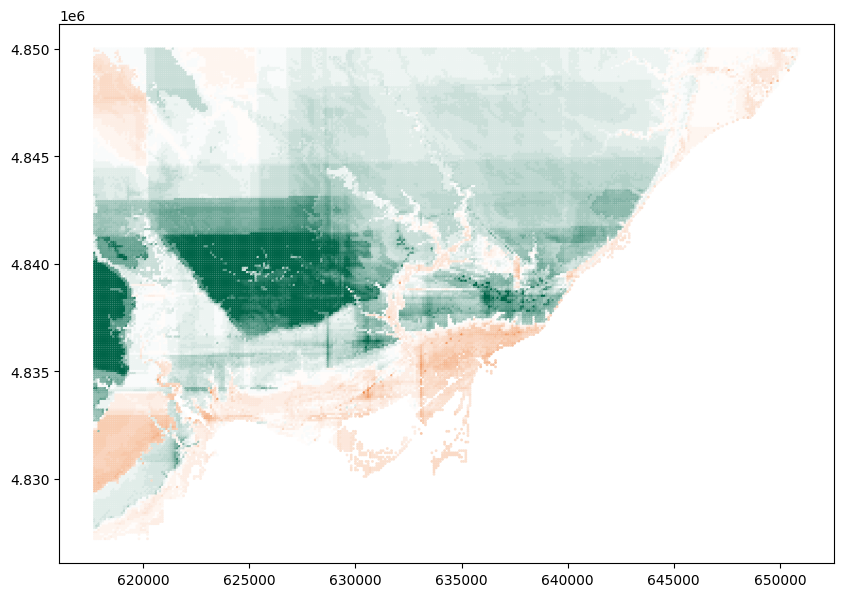

In [7]:
# View data
plt.figure(figsize=(10,7))
plt.scatter(data['utm_east'], data['utm_north'], c=data['ride_end_ratio'], cmap=cmap1, vmin=0, vmax=1, s=1)

### 3. PLOT RIDE-END RATIOS TO MAP<a class="anchor" id="3"></a>

In [8]:
# Input ranges for different colour markers
data_range = [0.45, 0.475, 0.525, 0.55]

# Get values for 4 different levels of ride-end ratios
lower_ride_end = data[data['ride_end_ratio'] < data_range[0]]
low_ride_end = data[(data['ride_end_ratio'] > data_range[0]) & (data['ride_end_ratio'] < data_range[1])]
high_ride_end = data[(data['ride_end_ratio'] > data_range[2]) & (data['ride_end_ratio'] < data_range[3])]
higher_ride_end = data[data['ride_end_ratio'] > data_range[3]]

In [9]:
# Plot high vs. low ride-end ratio areas to a map of Toronto
fig = Figure(width=700, height=450)
m = folium.Map(location=[43.67025, -79.38676], zoom_start=12)

for i, row in lower_ride_end.iterrows():
    folium.CircleMarker(location=[row.lat, row.lon], radius=2, color=c_1_hex, opacity=0.4).add_to(m)

for i, row in low_ride_end.iterrows():
    folium.CircleMarker(location=[row.lat, row.lon], radius=2, color=c_1_hex, opacity=0.2).add_to(m)

for i, row in high_ride_end.iterrows():
    folium.CircleMarker(location=[row.lat, row.lon], radius=2, color=c_2_hex, opacity=0.2).add_to(m)

for i, row in higher_ride_end.iterrows():
    folium.CircleMarker(location=[row.lat, row.lon], radius=2, color=c_2_hex, opacity=0.4).add_to(m)

fig.add_child(m)

As seen in the map above, the model predicts that bike stations located in North York, East York, and the north side of Etobicoke will tend to become empty, while stations in the east side of Toronto and the south side of Etobicoke will tend to become full. Stations located in York and the west side of Toronto will tend to have more balanced ride-start vs. ride-end usage. With this in mind, Bike Share Toronto can anticipate that new stations added to west Toronto and York will have less of a burden on the rebalancing team.

Bike Share Toronto can also use this map to more efficiently focus its rebalancing efforts. If bikes are moved from orange areas on the map to green areas, they will naturally trickle down to orange areas, over time.